In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph
from einops import rearrange
from tqdm import tqdm
import torch.nn.functional  as Fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from io import BytesIO
from IPython.display import Image as IPyImage, display
from PIL import Image
import matplotlib.pyplot as plt
import os
from piq import ssim
import gc


import wandb
wandb.login()

In [ ]:
wandb.init(
    project="VQVAE-Transformer",  
    name="experiment-1",    
    id="fe9htihr",  # Same ID as before
    resume="allow",
    config={                       
        "epochs": 100,
        "batch_size": 16,
    }
)

# wandb.init(
#     project="experiment-1",
#     id="VQVAE-Transformer",  # Same ID as before
#     resume="allow"  # or "must"
# )

Implementation
https://www.youtube.com/watch?v=1mi2MSvigcc&t=18s

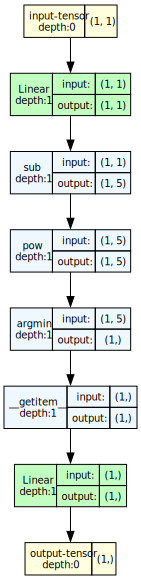

In [2]:
class VQVAEQuantizeWithoutDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithoutDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

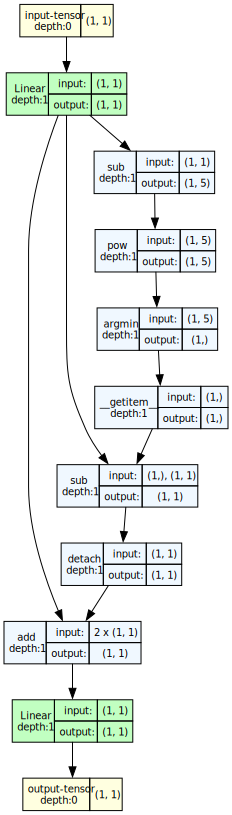

In [3]:
class VQVAEQuantizeWithDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_input = encoder_out + (decoder_input - encoder_out).detach()
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

In [4]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps
        self.dead_codeBook_threshold = codeBookDim * 0.6

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        log_encoding_sum = -torch.sum(avg_probs * torch.log(avg_probs + 1e-10))
        perplexity = torch.exp(log_encoding_sum)

        entropy = log_encoding_sum
        normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device))
        diversity_loss = 1.0 - normalized_entropy

        return quantized, encoding_indices, perplexity, diversity_loss
        
        
vq = VectorQuantizeImage(codeBookDim=64,embeddingDim=32)
rand = torch.randn(1024,32)
vq(rand)

(tensor([[-0.1587,  0.0366, -0.1281,  ...,  0.0686,  0.0623,  0.2255],
         [ 0.0676,  0.0580,  0.0157,  ..., -0.2351, -0.1430,  0.2306],
         [ 0.0368, -0.1608,  0.1530,  ...,  0.1785, -0.1391, -0.1805],
         ...,
         [ 0.1493,  0.0687, -0.1800,  ...,  0.0659, -0.2259,  0.0106],
         [-0.0821, -0.0571,  0.1529,  ...,  0.1269,  0.0457, -0.1416],
         [-0.2042,  0.1391,  0.0654,  ..., -0.2239,  0.2004, -0.1093]],
        grad_fn=<MmBackward0>),
 tensor([ 6, 27, 38,  ..., 49, 39, 35]),
 tensor(59.5959),
 tensor(0.0171))

In [5]:
class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 32, codeBookdim = 128, embedDim = 128):
        super().__init__()
        self.inChannels = inChannels
        self.hiddenDim = hiddenDim
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(inChannels, hiddenDim, 4, 2, 1), 
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, embedDim, 1),
        )

        self.vector_quantize = VectorQuantizeImage(codeBookDim=codeBookdim,embeddingDim=embedDim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(2 * hiddenDim, hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, inChannels, 1),
            nn.Sigmoid()
        )

    def encodeImage(self, x, noise_std = 0.15):
        if self.training:
            encodedOut = self.encoder(x)
            encodedOut = encodedOut + torch.randn_like(encodedOut) * noise_std
        else:
            encodedOut = self.encoder(x)

        return encodedOut

    def decodeImage(self, quantized_vector):
        decodedOut = self.decoder(quantized_vector)
        return decodedOut

    def forward(self, x):
        batch_size, inChannels, height, width = x.shape
        encodedOut = self.encodeImage(x)
        batch_size, encoded_channel, encoded_height, encoded_width = encodedOut.shape
        
        # print(f"Encoded Shape: {encodedOut.shape}")

        
        vectorize_input = rearrange(encodedOut, 'b c h w -> (b h w) c')
        quantized_vectors, encoding_indices, perplexity, diversity_loss  = self.vector_quantize(vectorize_input)
        codebook_loss = Fn.mse_loss(vectorize_input.detach(), quantized_vectors)
        commitment_loss = Fn.mse_loss(vectorize_input, quantized_vectors.detach())

        quantized_vectors = vectorize_input + (quantized_vectors - vectorize_input).detach()
        # print(f"CodeBook Loss: {codebook_loss} , Commitment Loss: {commitment_loss}")
        # print(f"Quantized SHape: {quantized_vectors.shape}")

        decoder_input = rearrange(quantized_vectors, '(b h w) d -> b d h w', d = encoded_channel, h = encoded_height, w = encoded_width)
        # print(f"Decoded Input SHape: {decoder_input.shape}")
        decodedOut = self.decodeImage(decoder_input)

        # print(f"Decoded SHape: {decodedOut.shape}")
        
        return decoder_input, decodedOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss

VQ = VecQVAE(inChannels = 1, hiddenDim = 256, codeBookdim = 128, embedDim = 64)
test = torch.randn(32, 1, 64, 64)
quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = VQ(test)
quantized_latents.shape, decoderOut.shape, codebook_loss, commitment_loss, encoding_indices.shape, perplexity, diversity_loss

(torch.Size([32, 64, 16, 16]),
 torch.Size([32, 1, 64, 64]),
 tensor(0.1733, grad_fn=<MseLossBackward0>),
 tensor(0.1733, grad_fn=<MseLossBackward0>),
 torch.Size([8192]),
 tensor(42.3701),
 tensor(0.2279))

In [6]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
print(data.shape)
flattened_frame_dataset = data.reshape(-1, 1, 64, 64)
print(flattened_frame_dataset.shape)
flattened_frame_dataset[0].shape

(20, 10000, 64, 64)
torch.Size([10000, 20, 1, 64, 64])
torch.Size([200000, 1, 64, 64])


torch.Size([1, 64, 64])

In [7]:
flattened_frame_dataset = data.reshape(-1, 1, 64, 64)
print(flattened_frame_dataset.shape)
flattened_frame_dataset[0].shape

torch.Size([200000, 1, 64, 64])


torch.Size([1, 64, 64])

In [8]:
class FrameDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.data = self.data/255.0
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.data[index]
    

test = torch.randn(1000, 1, 64, 64)
out = FrameDataset(test)
print(out.__len__())
x, y = out.__getitem__(0)
x.shape, y.shape


1000


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

In [9]:
codeBookdim = 128
embedDim = 64
hiddenDim = 256
inChannels = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torchDataset = FrameDataset(flattened_frame_dataset)
dataloader = DataLoader(torchDataset, batch_size=64, shuffle = True)
modelA = VecQVAE(inChannels = inChannels, hiddenDim = hiddenDim, codeBookdim = codeBookdim, embedDim = embedDim).to(device)
lossFn = nn.MSELoss()
optimizerA = torch.optim.Adam([
                    {'params': modelA.encoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.decoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.vector_quantize.parameters(), 'lr': 1e-4}
                ], weight_decay=1e-5)
schedulerA = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizerA, T_0=10, T_mult=2, eta_min=1e-6
            )

epochs = 1000

In [10]:
modelValA = torch.load("./model/VQVAE/vqvae.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

for each_epoch in range(epochs):
    modelA.train()
    reconstruct_loss = 0.0
    codeb_loss = 0.0
    commit_loss = 0.0
    vqvaeloss = 0.0
    diverse_loss = 0.0
    ssim_loss = 0.0
    
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    perplexities = []

    for X, Y in loop:
        X = X.to(device)
        Y = Y.to(device)
        # print(X.shape, Y.shape)
    #     break
    # break
        
        quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = modelA(X)

        ssim_score = ssim(Y, decoderOut, data_range=1.0)
        ssim_loss = 1.0 - ssim_score

        reconstruction_loss = torch.mean((Y - decoderOut)**2)
        
        loss = reconstruction_loss + codebook_loss + 0.2 * commitment_loss + 0.1 * diversity_loss + 0.1 * ssim_loss
        vqvaeloss += loss.item()

        
        reconstruct_loss += reconstruction_loss.item()
        diverse_loss += diversity_loss.item()
        codeb_loss += codebook_loss.item()
        commit_loss += commitment_loss.item()
        ssim_loss += ssim_loss.item()
        perplexities.append(perplexity)
        
        
        optimizerA.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelA.parameters(), max_norm=1.0)
        optimizerA.step()
        loop.set_postfix({"TotalL": f"{vqvaeloss}", "ReconsL": f"{reconstruct_loss}", "CodeL":f"{codeb_loss}",
                          "CommitL":f"{commitment_loss}", "Perplexity":f"{perplexity}", "Diversity Loss":f"{diverse_loss}", "SSIM Loss":f"{ssim_loss}"})
    #     break
    # break

    average_perplexity = sum(perplexities)/len(perplexities)
    vqvaeloss /= len(dataloader)   
    reconstruct_loss /= len(dataloader)   
    codeb_loss /= len(dataloader)   
    commit_loss /= len(dataloader)   
    diverse_loss /= len(dataloader)
    torch.save(modelA.state_dict(), "./model/VQVAE/vqvae.pt")
    wandb.log({
        "Epoch": each_epoch,
        "VQVAE LR": optimizerA.param_groups[0]['lr'],
        "VQVAE Loss": vqvaeloss,
        "Reconstruction Loss": reconstruct_loss,
        "Codebook Loss": codeb_loss,
        "Commitment Loss": commit_loss,
        "Diversity Loss": diverse_loss,
        "Perplexity": average_perplexity,
        "SSIM Loss":ssim_loss,
    })
    schedulerA.step()
 

0/1000:   0%|          | 1/3125 [00:06<5:57:20,  6.86s/it, TotalL=0.045000385493040085, ReconsL=0.0006636377656832337, CodeL=0.02427852153778076, CommitL=0.02427852153778076, Perplexity=62.87490463256836, Diversity Loss=0.14651250839233398, SSIM Loss=0.011025428771972656]


KeyboardInterrupt: 

In [10]:
modelValA = torch.load("./model/VQVAE/vqvae-5.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

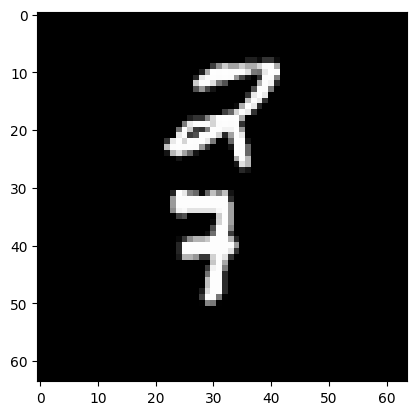

In [20]:
c = data[0][0].squeeze().numpy()
plt.imshow(c, cmap = 'gray')

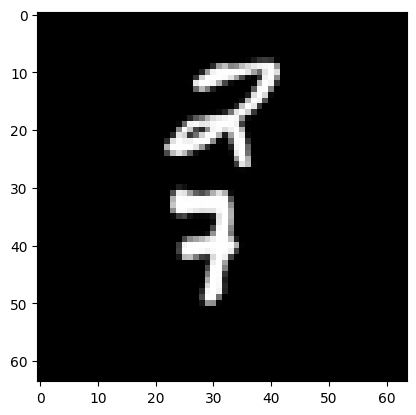

In [26]:
out = modelA.encodeImage(data[0][0].unsqueeze(0)/255.0)
decimg = modelA.decodeImage(out)
x = (decimg * 255.0).squeeze().squeeze().detach().numpy()
plt.imshow(x, cmap = 'gray')

torch.Size([1, 64, 64])

In [56]:
def testImages(imagepath, model):
    img = Image.open(imagepath)
    img = img.convert("L")
    img = img.resize((64, 64))
    img_array = np.array(img)
    img_array = np.array(img).astype(np.float32)
    
    tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)

    out_image, _, _, _, _, _, _ = model(tensor/255.0)
    out_image = model.decodeImage(out_image)
    out_image = out_image.squeeze()
    out_image = (out_image * 255).byte().cpu().numpy()

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(img_array, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Actual Image", fontsize=8)

    # Generated image
    axs[1].imshow(out_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Generated Image", fontsize=8)

    plt.tight_layout()
    plt.show()


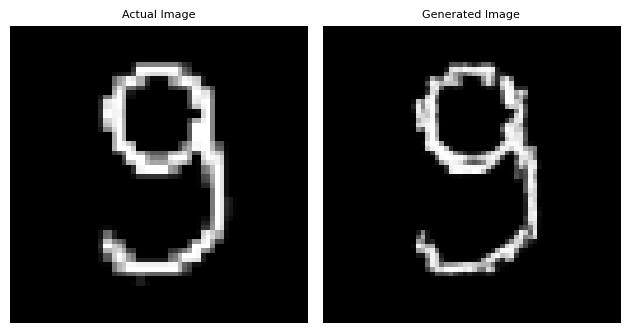

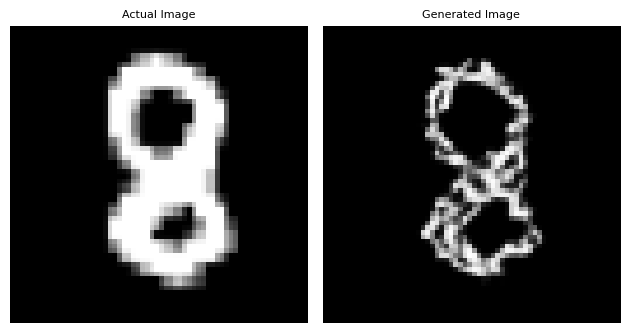

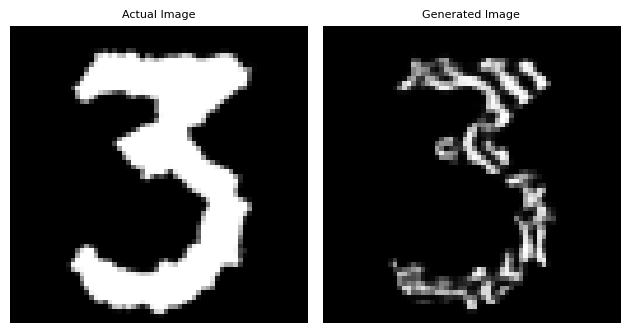

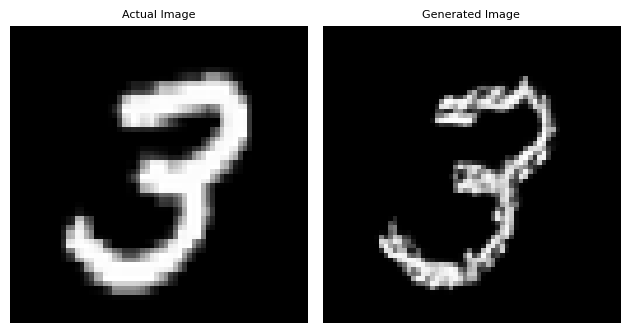

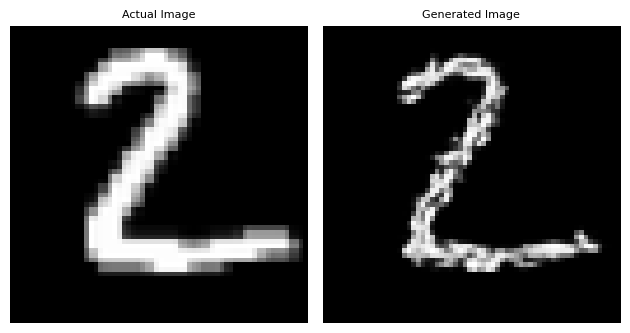

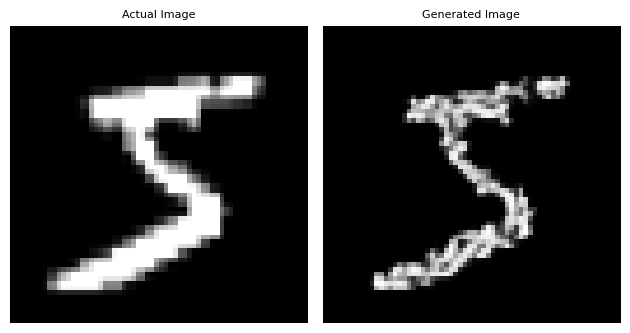

In [57]:
for i in os.listdir("data/testImages"):
    # print(i)
    testImages("data/testImages/"+i, modelA)

In [58]:
modelValA = torch.load("./model/VQVAE/vqvae-5.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

In [59]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data).to(dtype=torch.float32)

trainData, validationData = data[:9990], data[9990:]
trainData.shape, validationData.shape

(20, 10000, 64, 64)


(torch.Size([9990, 20, 64, 64]), torch.Size([10, 20, 64, 64]))

In [60]:
out1 = modelA.encodeImage(trainData[0][0].unsqueeze(0).unsqueeze(0))
out1 = out1.squeeze()
out1.shape

torch.Size([64, 16, 16])

In [61]:
out = modelA.encodeImage(trainData[0][:10].unsqueeze(1))
print(out.shape)
out[0].shape

torch.Size([10, 64, 16, 16])


torch.Size([64, 16, 16])

In [62]:
torch.equal(out1, out[0])

False

In [63]:
with torch.no_grad():
    modelA.eval()
    out1 = modelA.encodeImage(trainData[0][0].unsqueeze(0).unsqueeze(0)).squeeze()
    out = modelA.encodeImage(trainData[0][:10].unsqueeze(1))
    print(out.shape)
    print(torch.equal(out1, out[0]))

torch.Size([10, 64, 16, 16])
True


In [19]:
# input_seqs = []
# target_seqs = []
# for j in range(data.shape[0]):
#     for i in range(10):  
#         with torch.no_grad():
#             modelA.eval()            
#             input_seq = (data[j][i:i+10]).unsqueeze(1)   
#             target_seq = (data[j][i+1:i+11]).unsqueeze(1)
#     #         print(input_seq.shape, target_seq.shape)
#     #         break
#     # break
#             encodedInput = modelA.encodeImage(input_seq)  
#             encodedOutput = modelA.encodeImage(target_seq)  
#             input_seqs.append(encodedInput)
#             target_seqs.append(encodedOutput)

# input_seqs = np.array(input_seqs)
# target_seqs = np.array(target_seqs)

In [64]:
class VideoSequenceData(Dataset):

    def __init__(self, data, encoder, input_length = 10):
        super().__init__()

        self.data = data
        self.encoder = encoder.eval().to(device)
        self.input_length = input_length
        self.sequence_per_video = 20 - self.input_length
        self.total_samples = len(data) * self.sequence_per_video

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        video_idx = idx // self.sequence_per_video
        start = idx % self.sequence_per_video
        end = start + self.input_length + 1
        frames = self.data[video_idx, start:end]

        with torch.inference_mode():
            frames = frames/255.0
            frames = frames.to(device)
            encoded = self.encoder.encodeImage(frames)

        
        X = encoded[:-1]  
        Y = encoded[1:]
        print(X.shape, Y.shape)
        return X, Y

val = VideoSequenceData(data.unsqueeze(2), modelA)
a, b = val.__getitem__(1)
val.__len__()

torch.Size([10, 64, 16, 16]) torch.Size([10, 64, 16, 16])


100000

In [65]:
class TransformerDecoderModel(nn.Module):

    def __init__(self, height, width, channels, sequence_len, embedding_dim, num_layers, numHeads, feedForwardDim = 2048, drop = 0.2):
        super().__init__()

        self.height = height
        self.width = width
        self.channels = channels
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim
        self.position_embedding = nn.Embedding(sequence_len, embedding_dim)
        
        self.linear_projection = nn.Linear(height * width * channels, embedding_dim)

        self.decoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, 
                                                        nhead=numHeads, 
                                                        dim_feedforward=feedForwardDim, 
                                                        dropout=drop, 
                                                        batch_first=True)
        
        self.decoder = nn.TransformerEncoder(self.decoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(drop)

        self.output_layer = nn.Linear(embedding_dim, channels * height * width)
        

    def forward(self, x):
        batch_size, seq, channels, height, width = x.shape

        x_reshaped = rearrange(x, 'b s c h w -> b s (c h w)')
        # print(f"X Reshaped: {x_reshaped.shape}")
        linear_layer = self.linear_projection(x_reshaped)
        # print(f"Linear Output: {linear_layer.shape}")

        positions = torch.arange(0, self.sequence_len, device=x.device).unsqueeze(0)
        pos_embeds = self.position_embedding(positions)
    

        decoderInput = self.dropout(linear_layer + pos_embeds)
        # print(f"Decoder Input: {decoderInput.shape}")

        masking = torch.triu(torch.full((seq, seq), float('-inf')), diagonal=1)

        decoderOut = self.decoder(
            src=decoderInput,
            mask=masking
        )
        # print(f"Decoder Output: {decoderOut.shape}")

        out = self.output_layer(decoderOut)

        # print(f"Output: {out.shape}")

        out_reshaped = rearrange(out, 'b s (c h w) -> b s c h w', c = channels, h = height, w = width)
        return out_reshaped
    

tModel = TransformerDecoderModel(height=16, width=16, channels=64, sequence_len=10, embedding_dim=1024, num_layers=3, numHeads=4)

test = torch.randn(5, 10, 64, 16, 16)
out = tModel(test)
out.shape

torch.Size([5, 10, 64, 16, 16])

In [66]:
batch_size = 64
learning_rate = 3e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
numHeads = 4
dropout = 0.2
num_layers = 3
embed_dim = 1024

torchDataset = VideoSequenceData(data.unsqueeze(2), modelA)
dataloader = DataLoader(torchDataset, batch_size=batch_size, shuffle = True)
modelB = TransformerDecoderModel(height=16, width=16, channels=64, sequence_len=10, embedding_dim=embed_dim, num_layers=num_layers, numHeads=numHeads).to(device)
lossFn = nn.MSELoss()
optimizerB = torch.optim.AdamW(params=modelB.parameters(), lr=learning_rate, weight_decay=1e-5)
schedulerB = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizerB, T_0=10, T_mult=2, eta_min=1e-6
            )

epochs = 1000

In [ ]:
# modelValB = torch.load(".model/TDecoder/tdecoder.pt", map_location=torch.device('cpu'))
# modelB.load_state_dict(modelValB)

for each_epoch in range(epochs):
    modelB.train()
    lossVal = 0.0
    
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")

    for X, Y in loop:
        X = X.to(device)
        Y = Y.to(device)
        y_pred = modelB(X)
    #     break
    # break
        # print("y_pred shape:", y_pred.shape)
        # print("Y shape:", Y.shape)
        # print("y_pred min/max:", y_pred.min().item(), y_pred.max().item())
        # print("Y min/max:", Y.min().item(), Y.max().item())
        # print("Y dtype:", Y.dtype)

        loss = lossFn(y_pred, Y)
        
        lossVal += loss.item()
        
        
        optimizerB.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), max_norm=1.0)
        optimizerB.step()
        loop.set_postfix({"Total Loss: ": f"{lossVal}"})
    #     break
    # break

    lossVal /= len(dataloader)   
    
    torch.save(modelB.state_dict(), "./model/TDecoder/tdecoder.pt")
    wandb.log({
        "Epoch": each_epoch,
        "Transformer Decoder LR": optimizerB.param_groups[0]['lr'],
        "Transformer Loss": lossVal,
    })
    schedulerB.step()
 

In [67]:
modelValB = torch.load("model/TDECODER/tdecoder.pt", map_location=torch.device('cpu'))
modelB.load_state_dict(modelValB)

<All keys matched successfully>

In [70]:
X, Y = torchDataset.__getitem__(10)
# X = X.unsqueeze(0)
X.shape, Y.shape
X[0].shape

torch.Size([10, 64, 16, 16]) torch.Size([10, 64, 16, 16])


torch.Size([64, 16, 16])

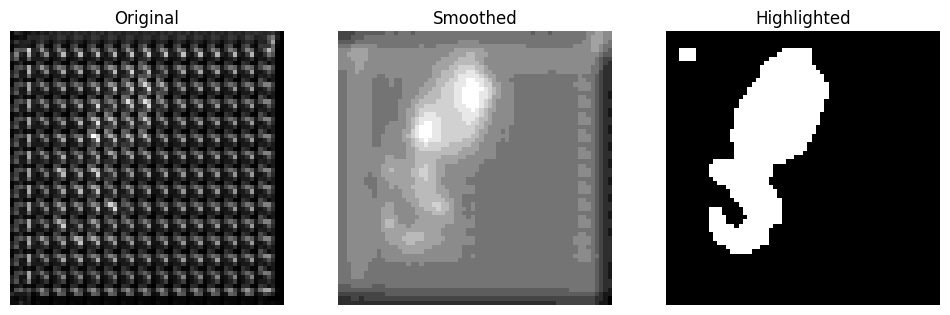

In [108]:
import cv2
with torch.inference_mode():
    out_image = modelA.decodeImage(Y[0].unsqueeze(0))
    # out_image = modelA.decodeImage(out_image)
    out_image = out_image.squeeze()
    out_image = (out_image * 255.0).byte().cpu().numpy()
    out_image = np.squeeze(out_image)  # Now shape is (H, W)

    # Step 1: Smooth using Gaussian Blur
    smoothed = cv2.GaussianBlur(out_image, (11, 11), sigmaX=0)

    # Step 2: Threshold to keep only the most highlighted parts
    # You can use a fixed threshold or Otsu's method
    _, highlighted = cv2.threshold(smoothed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Optional: Clean small noise
    kernel = np.ones((3, 3), np.uint8)
    highlighted = cv2.morphologyEx(highlighted, cv2.MORPH_OPEN, kernel)

    # Step 3: Show the result
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(out_image, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Smoothed")
    plt.imshow(smoothed, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Highlighted")
    plt.imshow(highlighted, cmap='gray')
    plt.axis("off")

    plt.show()
    # print(out_image)
    # plt.imshow(out_image)
    # plt.axis('off')
    # plt.tight_layout()
    # plt.show()


In [ ]:
img = Image.open(imagepath)
img = img.convert("L")
img = img.resize((64, 64))
img_array = np.array(img)
img_array = np.array(img).astype(np.float32)

tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)

out_image, _, _, _, _, _, _ = model(tensor/255.0)
out_image = model.decodeImage(out_image)
out_image = out_image.squeeze()
out_image = (out_image * 255).byte().cpu().numpy()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img_array, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Actual Image", fontsize=8)

# Generated image
axs[1].imshow(out_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Generated Image", fontsize=8)

plt.tight_layout()
plt.show()

In [30]:
X, Y = torchDataset.__getitem__(10)
X = X.unsqueeze(0)
X.shape, Y.shape


torch.Size([10, 64, 16, 16]) torch.Size([10, 64, 16, 16])


(torch.Size([1, 10, 64, 16, 16]), torch.Size([10, 64, 16, 16]))

In [ ]:
with torch.inference_mode():
    out = modelB(X)
    frame = modelA.decodeImage(out.squeeze())
    frame = frame.squeeze()
    # print(frame.shape)
    # visualizeData(frame.numpy())

tensor([[[0.3962, 0.5418, 0.5958,  ..., 0.5964, 0.4627, 0.4550],
         [0.6438, 0.6577, 0.5511,  ..., 0.4961, 0.5038, 0.5946],
         [0.7990, 0.8216, 0.3661,  ..., 0.4074, 0.8317, 0.8108],
         ...,
         [0.7739, 0.7745, 0.5636,  ..., 0.5191, 0.7701, 0.7976],
         [0.6738, 0.7540, 0.4441,  ..., 0.7362, 0.7460, 0.5659],
         [0.5269, 0.6176, 0.5994,  ..., 0.6131, 0.4271, 0.3876]],

        [[0.3872, 0.5257, 0.5939,  ..., 0.6486, 0.4847, 0.4941],
         [0.6205, 0.6314, 0.5382,  ..., 0.6201, 0.5781, 0.6537],
         [0.7725, 0.7760, 0.3414,  ..., 0.4730, 0.9063, 0.8406],
         ...,
         [0.8764, 0.9259, 0.7212,  ..., 0.4749, 0.6637, 0.7244],
         [0.7197, 0.9219, 0.5036,  ..., 0.6626, 0.6553, 0.5178],
         [0.5353, 0.7169, 0.6360,  ..., 0.5780, 0.4101, 0.3778]],

        [[0.3911, 0.5301, 0.5939,  ..., 0.6016, 0.4702, 0.4636],
         [0.6290, 0.6386, 0.5419,  ..., 0.5129, 0.5115, 0.6005],
         [0.7800, 0.7830, 0.3503,  ..., 0.4309, 0.8599, 0.

In [ ]:
def visualizeData(sequence):
    
    frames = [Image.fromarray((frame * 255).astype(np.uint8), mode='L') for frame in sequence]

    buffer = BytesIO()
    frames[0].save(
        buffer,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )

    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

# visualizeData(data[50])

In [37]:
modelValA = torch.load("model/VQVAE/transformer.pt", map_location=torch.device('mps'))
modelA.load_state_dict(modelValA)

modelValB = torch.load("model/VQVAE/vqvae.pt", map_location=torch.device('mps'))
modelB.load_state_dict(modelValB)


<All keys matched successfully>

In [ ]:
initial_frame = torch.from_numpy(data[0, 10]/255.0)

initial_frame.shape

torch.Size([64, 64])